In [58]:
import ot
from itertools import product
import numpy as np
N = 12
limits = [[-1, 1] for i in range(N)]
values = np.array(list(product(*limits)))

M = np.zeros((2**N, 2**N))
for i, p in enumerate(values):
    for j, q in enumerate(values[i+1:]):
        dist = np.linalg.norm(p- q, ord=1)
        M[i][j + i + 1] = dist
        M[j + i + 1][i] = dist
d1 = np.random.uniform(size=len(values))
d2 = np.random.uniform(size=len(values))
d1 /= d1.sum()
d2 /= d2.sum()
print("Calculating OT")
ot.emd2(d1, d2, M)

0.689646330807661

In [60]:
d1, d2

(array([3.05503069e-04, 2.74846293e-04, 3.83410490e-04, ...,
        4.43819064e-05, 1.01028793e-04, 3.06908733e-04]),
 array([8.28874655e-05, 1.66659367e-04, 4.88217256e-04, ...,
        3.83632097e-04, 4.81276191e-04, 1.22350907e-04]))

<Axes: >

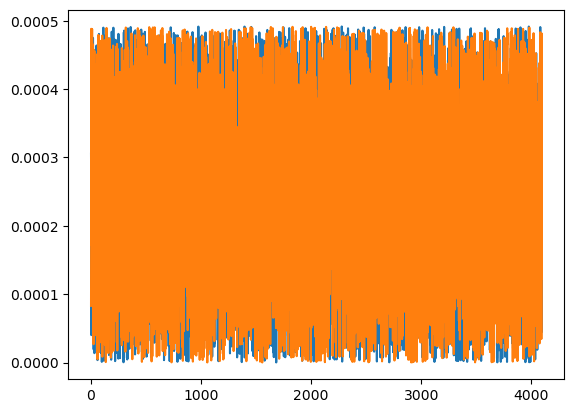

In [62]:
import seaborn as sns
sns.lineplot(d1)
sns.lineplot(d2)

In [17]:
distance.signature

In [7]:
import dwave_networkx as dnx
import tsplib95 as tsp
import networkx as nx
import dimod
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import re
import seaborn as sns
def read_ising(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        # h /= J.abs().max()
        # J /= J.abs().max()
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G
def row_elim(mat, blocks):
    remmat = mat
    for b in blocks:
        eye = np.eye(mat.shape[0])
        eye[b,:] = 0
        # print(eye.shape)
        remmat = eye @ remmat
        remmat[:, b] *= 2
        remmat = (remmat + remmat.T)/2
    
    return remmat
G27 = read_ising(os.environ['GSET']+'/set/G027')
A = nx.adjacency_matrix(G27).toarray()
eigvals, eigvecs = np.linalg.eigh(A)

In [9]:
np.abs(eigvals).mean()

3.763148692243674

In [3]:
data = []
whole_eig_data = []
for tspfile in tqdm(os.listdir('tsp_problems')):
    if '.tsp' not in tspfile:
        continue
    # prob = tsp.load(os.environ['BENCH']+f'/SunSet/external_benchmarks/tsp/{target}.tsp')
    prob = tsp.load('tsp_problems/'+tspfile)
    G = prob.get_graph()
    coeff = {30: 1.0, 35: 1.0, 20: 1.0, 25: 1.0}
    ncities = int(re.findall(r'TSP_(\d+)', tspfile)[0])
    qubo = dnx.traveling_salesman_qubo(
        G=nx.convert_node_labels_to_integers(G), 
        lagrange=coeff[ncities] * np.max([prob.get_weight(*i) for i in prob.get_edges()]))

    bqm = dimod.BQM.from_qubo(qubo)
    mapping = bqm.relabel_variables_as_integers()
    mat = np.array(bqm.to_numpy_matrix())
    mat /= np.abs(mat).max()
    mat = (mat.T + mat)/4
    maxeig = np.abs(np.linalg.eigvalsh(mat)).max()
    for block in [2,4,8]:
        blocks = np.array_split(np.arange(mat.shape[0]), block)
        JExt = row_elim(mat, blocks)
        data.append((ncities,block, np.abs(np.linalg.eigvalsh(JExt)).max(), maxeig))
    # print(mat)
    # print(tspfile, np.abs(np.linalg.eigvalsh(mat)).max())
    # bqm.change_vartype('SPIN')
    # arr = bqm.to_
    # h, J, offset = bqm.to_ising()
    # target = Path(tspfile).stem

    # with open(f'tsp_problems/tsp_ising/{target}.ising', 'w') as burmafile:
    #     burmafile.write(f'{bqm.num_variables} {len(h)} {len(J)}\n')
    #     for u, bias in h.items():
    #         burmafile.write(f'{u} {bias}\n')
    #     for (u, v), bias in J.items():
    #         burmafile.write(f'{u} {v} {bias}\n')

  0%|          | 0/161 [00:00<?, ?it/s]/tmp/ipykernel_64556/3154277232.py:17: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  mat = np.array(bqm.to_numpy_matrix())
100%|██████████| 161/161 [00:55<00:00,  2.92it/s]


In [4]:
df = pd.DataFrame(data, columns=['cities','blocks','eig','wholeeig'])

In [5]:
def sigfigs(input, sf=2):
    norm = 10**np.ceil(np.log10(input))
    return np.round((np.round(input / norm, decimals=sf) * norm), decimals=sf)
sigfigs(0.1)

0.1

In [6]:
df['spins'] = df['cities']**2
agg_df = df.groupby(['cities', 'spins', 'blocks']).agg(['mean', 'std'])
agg_df['LExt'] = "$"+sigfigs(agg_df[('eig', 'mean')], 3).astype(str) +"\pm" + sigfigs(agg_df[('eig', 'std')], 2).astype(str) +"$"

agg_df['L'] = "$"+sigfigs(agg_df[('wholeeig', 'mean')], 3).astype(str) +"\pm" + sigfigs(agg_df[('wholeeig', 'std')], 2).astype(str) +"$"
agg_df = agg_df.reset_index()
agg_df = agg_df.groupby(['cities', 'spins', 'blocks']).max()
print(agg_df[['LExt']].to_latex(escape=False))

\begin{tabular}{llll}
\toprule
 &  &  & LExt \\
 &  &  &  \\
cities & spins & blocks &  \\
\midrule
\multirow[t]{3}{*}{20} & \multirow[t]{3}{*}{400} & 2 & $3.67\pm0.09$ \\
 &  & 4 & $5.51\pm0.13$ \\
 &  & 8 & $7.06\pm0.14$ \\
\cline{1-4} \cline{2-4}
\multirow[t]{3}{*}{25} & \multirow[t]{3}{*}{625} & 2 & $4.85\pm0.09$ \\
 &  & 4 & $7.29\pm0.15$ \\
 &  & 8 & $8.84\pm0.17$ \\
\cline{1-4} \cline{2-4}
\multirow[t]{3}{*}{30} & \multirow[t]{3}{*}{900} & 2 & $5.42\pm0.11$ \\
 &  & 4 & $8.53\pm0.15$ \\
 &  & 8 & $10.4\pm0.17$ \\
\cline{1-4} \cline{2-4}
\multirow[t]{3}{*}{35} & \multirow[t]{3}{*}{1225} & 2 & $6.66\pm0.1$ \\
 &  & 4 & $9.99\pm0.16$ \\
 &  & 8 & $12.0\pm0.19$ \\
\cline{1-4} \cline{2-4}
\bottomrule
\end{tabular}



/tmp/ipykernel_64556/2773897068.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  agg_df = agg_df.groupby(['cities', 'spins', 'blocks']).max()


In [62]:
agg_df

eig             wholeeig            \
                                   mean       std       mean       std   
cities spins L        blocks                                             
20     400   $11\pm0$ 2        3.668906  0.089655  11.227654  0.153872   
                      4        5.513127  0.130261  11.227654  0.153872   
                      8        7.058153  0.139566  11.227654  0.153872   
25     625   $14\pm0$ 2        4.850395  0.091835  14.206869  0.193124   
                      4        7.290497  0.147002  14.206869  0.193124   
                      8        8.842739  0.170702  14.206869  0.193124   
30     900   $17\pm0$ 2        5.418986  0.111192  17.222813  0.179834   
                      4        8.528393  0.150919  17.222813  0.179834   
                      8       10.370351  0.168729  17.222813  0.179834   
35     1225  $20\pm0$ 2        6.655523  0.102873  20.289995  0.202142   
                      4        9.985475  0.157034  20.289995  0.202142   
                      8       11.974023  0.186611  20.289995  0.202142   

                                  LExt  
                                        
cities spins L        blocks            
20     400   $11\pm0$ 2        $3\pm0$  
                      4        $5\pm0$  
                      8        $7\pm0$  
25     625   $14\pm0$ 2        $4\pm0$  
                      4        $7\pm0$  
                      8        $8\pm0$  
30     900   $17\pm0$ 2        $5\pm0$  
                      4        $8\pm0$  
                      8       $10\pm0$  
35     1225  $20\pm0$ 2        $6\pm0$  
                      4        $9\pm0$  
                      8       $12\pm0$

In [61]:
from scipy.optimize import curve_fit
yvals = np.array(df['wholeeig'])
xvals = np.array(df['cities'])
def poly_fit(x, a, b):
    return a * (x**b)
print(curve_fit(xdata=xvals, ydata=yvals, f=poly_fit))

(array([0.47191078, 1.05778212]), array([[ 1.90725850e-05, -1.19288397e-05],
       [-1.19288397e-05,  7.48393368e-06]]))


In [56]:
from scipy.optimize import curve_fit
for b, mdf in df.groupby('blocks'):
    yvals = np.array(mdf['eig'])
    xvals = np.array(mdf['cities'])
    def poly_fit(x, a, b):
        return a * (x**b)
    print(b, curve_fit(xdata=xvals, ydata=yvals, f=poly_fit))
for b, mdf in df.groupby('cities'):
    yvals = np.array(mdf['eig'])
    xvals = np.array(mdf['blocks'])
    def poly_fit(x, a, b):
        return a * (x**b)
    print(b, curve_fit(xdata=xvals, ydata=yvals, f=poly_fit))

2 (array([0.1756536 , 1.01910646]), array([[ 6.83788076e-05, -1.14988127e-04],
       [-1.14988127e-04,  1.93974791e-04]]))
4 (array([0.2617687 , 1.02524052]), array([[ 7.64545008e-05, -8.62584117e-05],
       [-8.62584117e-05,  9.76242866e-05]]))
8 (array([0.43508442, 0.93275158]), array([[ 1.17390527e-04, -7.98380218e-05],
       [-7.98380218e-05,  5.44736621e-05]]))
20 (array([2.82350033, 0.44717548]), array([[ 1.26865461e-03, -2.47331221e-04],
       [-2.47331221e-04,  5.29031508e-05]]))
25 (array([3.90276448, 0.40286871]), array([[ 3.60176487e-03, -5.12526713e-04],
       [-5.12526713e-04,  8.04768922e-05]]))
30 (array([4.34864513, 0.42895575]), array([[ 0.00615499, -0.0007819 ],
       [-0.0007819 ,  0.00010923]]))
35 (array([5.40472523, 0.39268292]), array([[ 7.05915983e-03, -7.26900650e-04],
       [-7.26900650e-04,  8.27051698e-05]]))


In [57]:
from scipy.optimize import curve_fit
yvals = np.array(df['wholeeig'])
xvals = np.array(df['cities'])
def poly_fit(x, a, b):
    return a * (x**b)
print(curve_fit(xdata=xvals, ydata=yvals, f=poly_fit))

(array([0.47191078, 1.05778212]), array([[ 1.90725850e-05, -1.19288397e-05],
       [-1.19288397e-05,  7.48393368e-06]]))


In [ ]:
df['spins'] = df['cities']**2
agg_df = df.groupby(['cities', 'spins', 'blocks']).agg(['mean', 'std'])
agg_df['LExt'] = "$"+sigfigs(agg_df[('eig', 'mean')], 3).astype(str) +"\pm" + sigfigs(agg_df[('eig', 'std')], 2).astype(str) +"$"

agg_df['L'] = "$"+sigfigs(agg_df[('wholeeig', 'mean')], 3).astype(str) +"\pm" + sigfigs(agg_df[('wholeeig', 'std')], 2).astype(str) +"$"
print(agg_df[['L', 'LExt']].to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
 &  &  & L & LExt \\
 &  &  &  &  \\
cities & spins & blocks &  &  \\
\midrule
\multirow[t]{3}{*}{20} & \multirow[t]{3}{*}{400} & 2 & $25000\pm2300$ & $8169\pm710$ \\
 &  & 4 & $25000\pm2300$ & $12300\pm1100$ \\
 &  & 8 & $25000\pm2300$ & $15700\pm1400$ \\
\cline{1-5} \cline{2-5}
\multirow[t]{3}{*}{25} & \multirow[t]{3}{*}{625} & 2 & $32800\pm2500$ & $11200\pm850$ \\
 &  & 4 & $32800\pm2500$ & $16800\pm1200$ \\
 &  & 8 & $32800\pm2500$ & $20400\pm1500$ \\
\cline{1-5} \cline{2-5}
\multirow[t]{3}{*}{30} & \multirow[t]{3}{*}{900} & 2 & $41200\pm2400$ & $12900\pm710$ \\
 &  & 4 & $41200\pm2400$ & $20400\pm1100$ \\
 &  & 8 & $41200\pm2400$ & $24800\pm1400$ \\
\cline{1-5} \cline{2-5}
\multirow[t]{3}{*}{35} & \multirow[t]{3}{*}{1225} & 2 & $48000\pm2400$ & $15700\pm810$ \\
 &  & 4 & $48000\pm2400$ & $23600\pm1200$ \\
 &  & 8 & $48000\pm2400$ & $28299\pm1400$ \\
\cline{1-5} \cline{2-5}
\bottomrule
\end{tabular}



In [4]:
def get_tour(ncities, spinvec, selected = -1):
    order = -np.ones(ncities)
    spinvec = (spinvec > 0).astype(int) - (spinvec < 0).astype(int)
    for i in range(0, len(spinvec), ncities):
        loc = np.where(spinvec[i:i+ncities]==selected)[0]
        order[loc[0]] = i // ncities + 1
    return order.astype(int)
def is_feasible( spinvec, selected: float = -1.0):
    ncities = int(round(np.sqrt(len(spinvec))))
    order = -np.ones(ncities)
    spinvec = (spinvec > 0).astype(int) - (spinvec < 0).astype(int)
    if (spinvec == selected).sum() != ncities:
        
        return False
    for i in range(0, len(spinvec), ncities):
        loc = np.where(spinvec[i:i+ncities]==selected)[0]
        if loc.shape[0] == 0:
            return False
        order[loc[0]] = i // ncities
    if (order == -1).any():
        return False
    return True


In [7]:
df

,prob,blocks,tstop,beta0,beta1,epoch,beta0.1,beta1.1,mean_gs,std_gs,spin,graph
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2.0,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2.0,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2.0,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...,NaN,NaN,NaN
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2.0,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2.0,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8.0,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8.0,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8.0,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8.0,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN


In [9]:
df

,prob,blocks,tstop,beta0,beta1,epoch,beta0.1,beta1.1,mean_gs,std_gs,spin,beta1 3B1495ABF04C49B47791A2061593BC11AB9FEA62F8E67AC4FC95F0C7CE88519DA826E525D6D7B341F47929BBA451FDEDECA44A930665A725F70D9A487A42A6AC6DC975558B0CD30DFD533EDD9740B4E58AE4954490A59E08E6A21904F4A30FDE2E44F022F3CAEBC79F0A87E21CAD7B2E88F0FFE5A4B5AF90E9EC0D8D9357FD05ACB77D70B4CC06B1641CEAE6533ADE6FAE4CC3F3648B8F9C87A8EF1F2784BF1875136199380A256CB0E250122F122615E0A9FB23B6E3FC66A6BB33AB247569985CFC6CB27DD4F4B7FE2D374F68076F70456AF38C75C937D3C636105ED2732CBCE33725BE1EBDC453F37098A1C384D2630147625A286CCFF83BD8,cities
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,20
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,20
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...,NaN,NaN,NaN,20
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,20
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,35
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35


In [ ]:
df = pd.read_csv('./rng_tsp_block_4_log.csv')


In [21]:
# df = df.drop(columns=['beta0.1','beta1.1'])
df

,prob,blocks,tstop,beta0,beta1,epoch,beta0.1,beta1.1,mean_gs,std_gs,spin,Unnamed: 0,cities
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,20
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,20
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...,NaN,NaN,NaN,20
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,20
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,NaN,35
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,NaN,35


In [24]:
pd.read_csv('./rng_tsp_block_8_log.csv')

,prob,blocks,tstop,beta0,beta1,epoch,beta0.1,beta1.1,mean_gs,std_gs,spin
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,0.012017,1.0,22,-21.456303,0.005663,1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,0.012017,1.0,22,-21.456303,0.005663,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,0.012017,1.0,22,-21.456303,0.005663,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,0.012017,1.0,22,-21.456303,0.005663,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1...,NaN,NaN
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,0.012017,1.0,22,-21.456303,0.005663,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,1.0,46,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN


In [37]:
pd.read_csv('./rng_tsp_block_2_log.csv')

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,spin
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....
...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,2,136.0,36.802263,1.0,46.0,-39.866299,0.005947,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,2,136.0,36.802263,1.0,46.0,-39.866299,0.005947,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,2,136.0,36.802263,1.0,46.0,-39.866299,0.005947,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,2,136.0,36.802263,1.0,46.0,-39.866299,0.005947,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....


In [49]:
df2 = pd.read_csv('rng_tsp_block_8_log.csv')
df2 = df2.rename(columns={'beta0':'epoch',
                          'beta0': 'epoch',
                          'epoch': 'beta1',
                          'beta0.1': 'mean_gs',
                          'beta1.1': 'std_gs',
                          'mean_gs': 'spin'})
df2.to_csv('./rng_tsp_block_8_log.csv', index=False)
# df2

In [47]:
pd.read_csv('rng_tsp_block_8_log.csv')

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,beta0.1,beta1.1,cities
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,22.0,0.012017,1.0,1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1...,-21.456303,0.005663,20
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,22.0,0.012017,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-21.456303,0.005663,20
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,22.0,0.012017,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-21.456303,0.005663,20
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,22.0,0.012017,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1...,-21.456303,0.005663,20
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,8,136.0,22.0,0.012017,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-21.456303,0.005663,20
...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,46.0,36.802263,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-39.732140,0.022561,35
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,46.0,36.802263,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-39.732140,0.022561,35
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,46.0,36.802263,1.0,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,-39.732140,0.022561,35
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,46.0,36.802263,1.0,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,-39.732140,0.022561,35


In [2]:
import pandas as pd
def sign(x):
    return int(x > 0) - int(x < 0)
sign = np.vectorize(sign)
df = pd.concat([pd.read_csv('./rng_tsp_block_1_log_2.csv'),pd.read_csv('./rng_tsp_block_2_log_2.csv'), pd.read_csv('./rng_tsp_block_4_log_2.csv'), pd.read_csv('./rng_tsp_block_8_log_2.csv')])
df['cities'] = df['prob'].str.extract(r'RNG_TSP_(\d+)').astype(int)
# df['spin']
states = [sign(np.array(i.strip().split(':')).astype(float)) for i in df['spin']]
# ncities = int(np.round(np.sqrt(states[0].shape[0])))
# # tours = [prob.trace_tours([get_tour(ncities, i)])[0] if feasible[ind] else np.nan for ind, i in enumerate(states)]
# # tourprob.trace_tours(tours)
# df['feasible'] = feasible
# # df['tours'] = tours
# df['epoch'] *= 31e4*50e-15
# df['Bandwidth (Gbps)'] = df['cities']**2 / df['epoch'] / (2 << 30)
# # df['ARPD'] = (df['tours'] - 2020)/2020*100


In [7]:
df['feasible'] = [is_feasible(i) for i in states]

df['feasible'].mean()

0.0

In [75]:
df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,spin,Unnamed: 0,beta1.1,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps)
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...,NaN,NaN,20,False,1.862645e-10,5.368709e+09,1000.0
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...,NaN,NaN,20,False,1.862645e-10,5.368709e+09,1000.0
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0


In [20]:
df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps)
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0


In [5]:
df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps)
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
479998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0


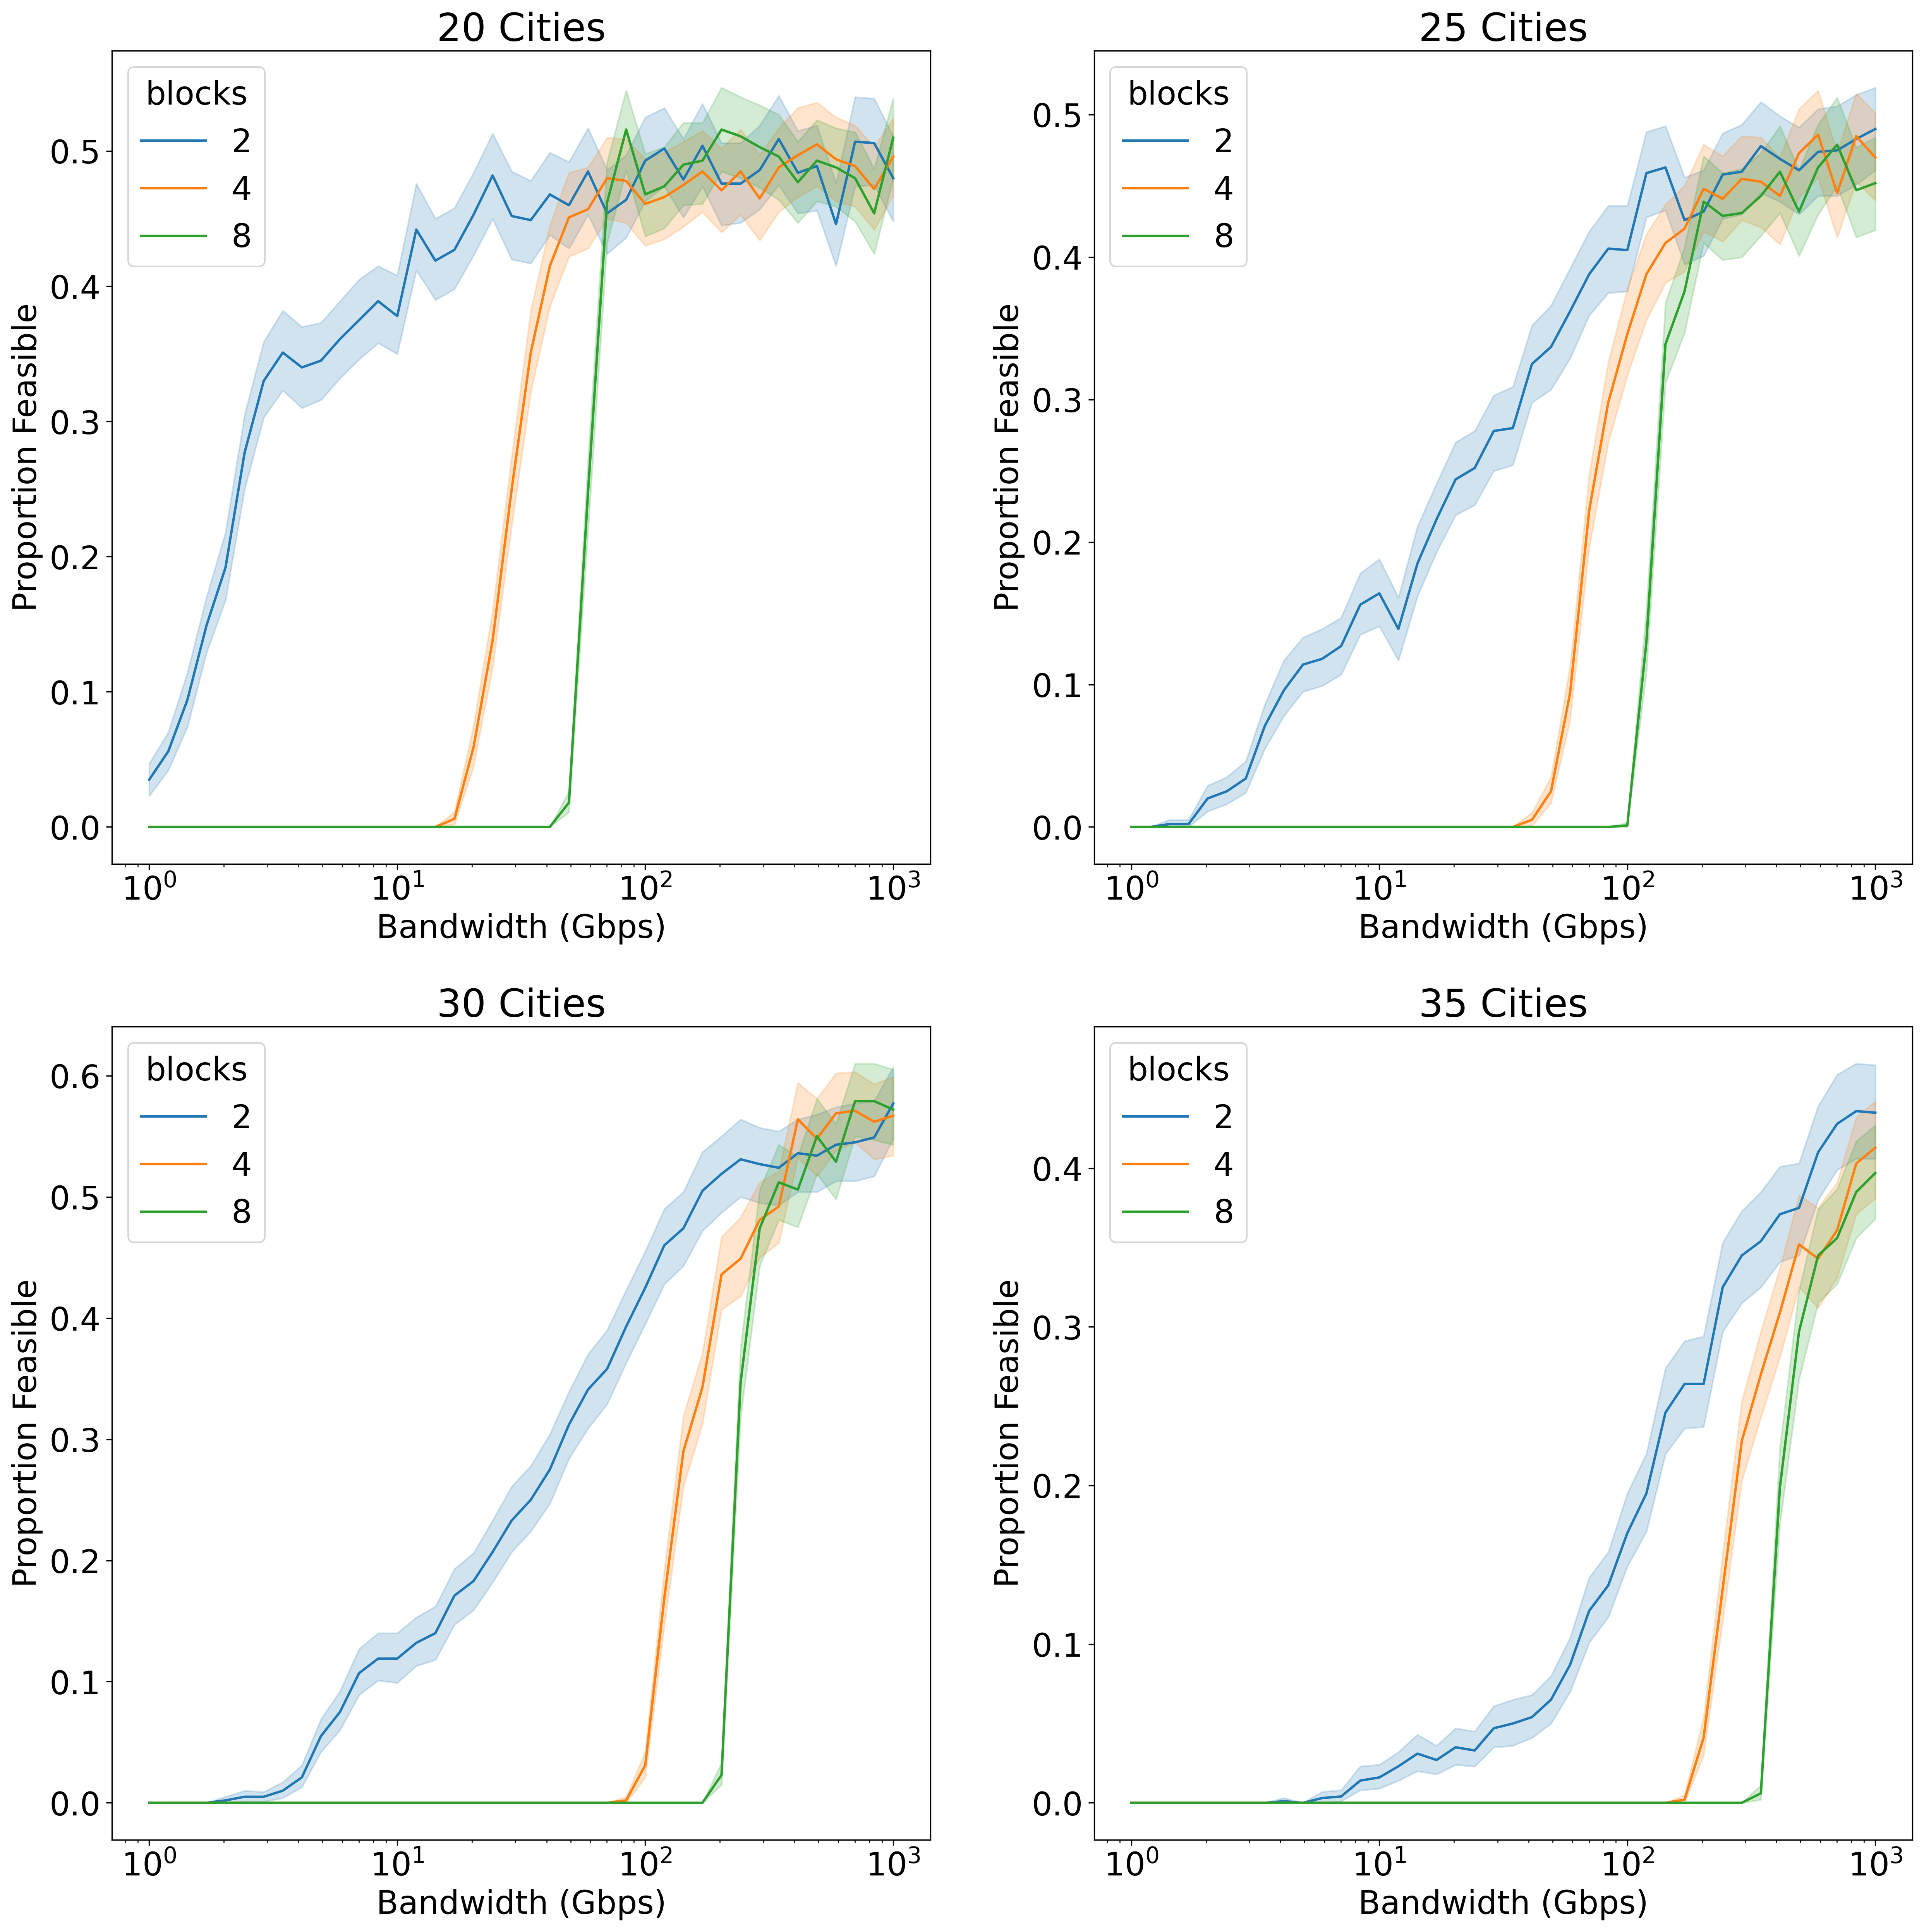

In [13]:
df = pd.read_csv('rng_euc2d_feasibility.csv')
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20), dpi=300)
ax=axs[0][0]
sns.lineplot(ax=ax, data=df.query('cities==20'), hue='blocks', x='Bandwidth (Gbps)', y='feasible', palette='tab10')
ax.set_xscale('log')
ax.set_title(f'20 Cities')

ax=axs[0][1]
sns.lineplot(ax=ax, data=df.query('cities==25'), hue='blocks', x='Bandwidth (Gbps)', y='feasible', palette='tab10')
ax.set_xscale('log')
ax.set_title(f'25 Cities')

ax=axs[1][0]
sns.lineplot(ax=ax, data=df.query('cities==30'), hue='blocks', x='Bandwidth (Gbps)', y='feasible', palette='tab10')
ax.set_xscale('log')
ax.set_title(f'30 Cities')

ax=axs[1][1]
sns.lineplot(ax=ax, data=df.query('cities==35'), hue='blocks', x='Bandwidth (Gbps)', y='feasible', palette='tab10')
ax.set_xscale('log')
ax.set_title(f'35 Cities')
for ax in axs.flatten():
    ax.set_ylabel('Proportion Feasible')

In [69]:
df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,spin,Unnamed: 0,beta1.1,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps)
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:-1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1...,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1...,NaN,NaN,20,False,1.862645e-10,5.368709e+09,1000.0
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:-1...,NaN,NaN,20,False,1.862645e-10,5.368709e+09,1000.0
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,NaN,20,True,1.862645e-10,5.368709e+09,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:-1.0:1.0:1.0:1.0:1.0:1...,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1.0:1....,NaN,1.0,35,False,5.704351e-07,1.753048e+06,1.0


In [71]:
compressed_df

,prob,blocks,tstop,epoch,beta0,beta1,mean_gs,std_gs,cities,feasible,epoch_real,sync_frequency,Bandwidth (Gbps)
0,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
1,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
2,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,False,1.862645e-10,5.368709e+09,1000.0
3,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
4,tsp_problems/tsp_ising/RNG_TSP_20_0.ising,2,136.0,0.012017,1.0,22.0,-21.457119,0.004855,20,True,1.862645e-10,5.368709e+09,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
159996,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
159997,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0
159998,tsp_problems/tsp_ising/RNG_TSP_35_9.ising,8,136.0,36.802263,NaN,46.0,-39.732140,0.022561,35,False,5.704351e-07,1.753048e+06,1.0


In [73]:
compressed_df = df.drop(columns=['spin', 'Unnamed: 0', 'beta1.1'])
compressed_df.to_csv('rng_euc2d_feasibility.csv', index=False)
summary_df = compressed_df.groupby(['blocks', 'epoch', 'cities']).mean(numeric_only=True)
summary_df.to_csv('rng_euc2d_feasibility_summary.csv', index=False)


In [ ]:

ax=sns.lineplot(color='r',data=df.query('cities=='), hue='blocks', x='Bandwidth (Gbps)', y='feasible', palette='tab10')
ax.set_xscale('log')

In [ ]:
df

<Axes: xlabel='epoch', ylabel='feasible'>

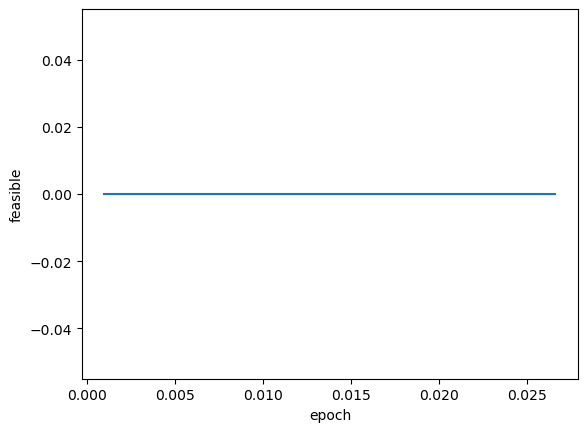

<Axes: xlabel='beta1.1', ylabel='beta0.1'>

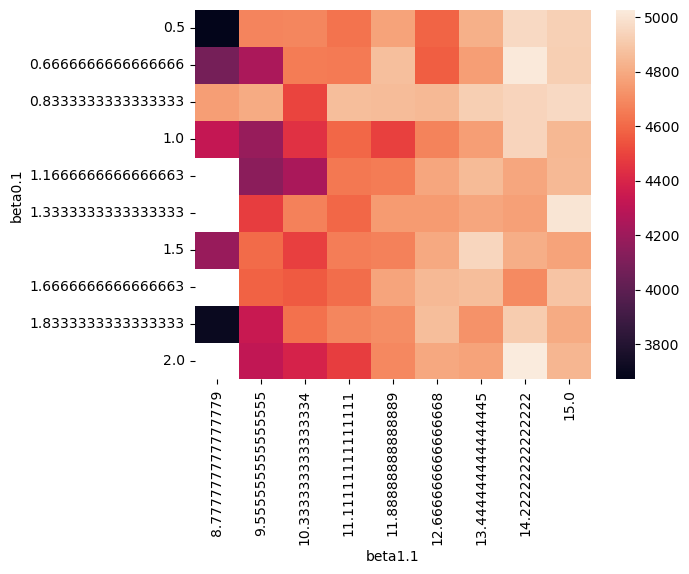

In [10]:
df['feasible'] = feasible
sns.heatmap(df.pivot_table(index='beta0.1', values='tours', columns='beta1.1', aggfunc='mean'))

In [1]:
import pandas as pd
from itertools import product

In [11]:
vals = [(0, 1) for i in range(4)]
data = []
for l1, l2, l3, l4 in product(*vals):
    v1 = int(l1 or l2 or l3 or l4)
    x5 = True
    v2 = int((l1 or l2 or x5) and ((not x5) or l3 or l4))
    v3 = int((l1 or l2 or (not x5)) and ((x5) or l3 or l4))
    data.append((l1, l2, l3, l4, v1, v2, v3))

In [24]:
df = pd.DataFrame(data, 
                  columns=['$\\ell_1$', '$\\ell_2$', '$\\ell_3$', '$\\ell_4$', '$f$', '$f_{new}(x_5=1)$', '$f_{new}(x_5=0)$'])
df.loc[df['$f$'] == df['$f_{new}(x_5=1)$'], '$f_{new}(x_5=1)$'] = '\\textbf{' + df.loc[df['$f$'] == df['$f_{new}(x_5=1)$']]['$f_{new}(x_5=1)$'].astype(str) + "}"
df.loc[df['$f$'] == df['$f_{new}(x_5=0)$'], '$f_{new}(x_5=0)$'] = '\\textbf{' + df.loc[df['$f$'] == df['$f_{new}(x_5=0)$']]['$f_{new}(x_5=0)$'].astype(str) + "}"
print(df.to_latex(escape=False, index=False))

\begin{tabular}{rrrrrll}
\toprule
$\ell_1$ & $\ell_2$ & $\ell_3$ & $\ell_4$ & $f$ & $f_{new}(x_5=1)$ & $f_{new}(x_5=0)$ \\
\midrule
0 & 0 & 0 & 0 & 0 & \textbf{0} & \textbf{0} \\
0 & 0 & 0 & 1 & 1 & \textbf{1} & 0 \\
0 & 0 & 1 & 0 & 1 & \textbf{1} & 0 \\
0 & 0 & 1 & 1 & 1 & \textbf{1} & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & \textbf{1} \\
0 & 1 & 0 & 1 & 1 & \textbf{1} & \textbf{1} \\
0 & 1 & 1 & 0 & 1 & \textbf{1} & \textbf{1} \\
0 & 1 & 1 & 1 & 1 & \textbf{1} & \textbf{1} \\
1 & 0 & 0 & 0 & 1 & 0 & \textbf{1} \\
1 & 0 & 0 & 1 & 1 & \textbf{1} & \textbf{1} \\
1 & 0 & 1 & 0 & 1 & \textbf{1} & \textbf{1} \\
1 & 0 & 1 & 1 & 1 & \textbf{1} & \textbf{1} \\
1 & 1 & 0 & 0 & 1 & 0 & \textbf{1} \\
1 & 1 & 0 & 1 & 1 & \textbf{1} & \textbf{1} \\
1 & 1 & 1 & 0 & 1 & \textbf{1} & \textbf{1} \\
1 & 1 & 1 & 1 & 1 & \textbf{1} & \textbf{1} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8877/1433086845.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['\\textbf{0}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}'
 '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}'
 '\\textbf{1}' '\\textbf{1}' '\\textbf{1}']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['$f$'] == df['$f_{new}(x_5=1)$'], '$f_{new}(x_5=1)$'] = '\\textbf{' + df.loc[df['$f$'] == df['$f_{new}(x_5=1)$']]['$f_{new}(x_5=1)$'].astype(str) + "}"
/tmp/ipykernel_8877/1433086845.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['\\textbf{0}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}'
 '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}' '\\textbf{1}'
 '\\textbf{1}' '\\textbf{1}' '\\textbf{1}']' has dtype incompatible with int64, please e